In [12]:
from IPython.display import display, HTML
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

import torch
import time
use_device = "cuda:0"
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device(use_device) #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)
%matplotlib inline

#device: 1
device#: 0
device name: NVIDIA GeForce RTX 2080

torch: 2.6.0+cu126
cuda:  12.6
cudnn: 90501
dtype: torch.float32


# File locations

In [4]:
input_dir = root_dir + "output/multisubject/"
joined_model_dir = input_dir + 'gnet8j_mpf_evc_1_all_May-04-2025_2344/' 
roiwise_model_dir = input_dir + 'gnet8r_mpf_evc_1_all_May-03-2025_1605/'# 'gnet8r_mpf_evc_Feb-04-2022_1844/'
output_dir = joined_model_dir

---
# Reload files

In [13]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]
roi_group_names = ['V1', 'V2', 'V3', 'hV4']
roi_group = [[1,2],[3,4],[5,6], [7]]

joined_checkpoint = torch.load(joined_model_dir + 'model_params_1_all_epoch20', map_location=use_device, weights_only=False)
subjects = list(joined_checkpoint['voxel_mask'].keys())
gnet8j_voxel_mask = joined_checkpoint['voxel_mask']
gnet8j_voxel_roi  = joined_checkpoint['voxel_roi']
gnet8j_voxel_index= joined_checkpoint['voxel_index']
gnet8j_brain_nii_shape= joined_checkpoint['brain_nii_shape']
gnet8j_val_cc = joined_checkpoint['val_cc']

roiwise_model_dirs = {
    'V1': '%smodel_params_V1_1_all_epoch20' % roiwise_model_dir,
    'V2': '%smodel_params_V2_1_all_epoch20' % roiwise_model_dir,
    'V3': '%smodel_params_V3_1_all_epoch20' % roiwise_model_dir,
    'hV4': '%smodel_params_hV4_1_all_epoch20' % roiwise_model_dir
    }

roiwise_checkpoint = {}
for r,t in roiwise_model_dirs.items():
    roiwise_checkpoint[r] = torch.load(t, map_location=use_device,weights_only=False)

cp = roiwise_checkpoint[list(roiwise_model_dirs.keys())[0]]
subjects = list(cp['voxel_mask'].keys())
gnet8r_voxel_mask = cp['voxel_mask']
gnet8r_voxel_roi  = cp['voxel_roi']
gnet8r_voxel_index= cp['voxel_index']
gnet8r_brain_nii_shape= cp['brain_nii_shape']
#these masks should be the same for all model components

gnet8r_val_cc = {s: np.zeros_like(v).astype(np.float32) for s,v in gnet8r_voxel_roi.items()}

for k,(roi_name, cp) in enumerate(roiwise_checkpoint.items()):
    for s in gnet8r_voxel_roi.keys():
        group_mask = cp['group_mask'][s][:len(gnet8r_val_cc[s])]
        gnet8r_val_cc[s][group_mask] = cp['val_cc'][s][:len(gnet8r_val_cc[s])]

---
# Load NSD Data

In [14]:
voxel_data_set = h5py.File(voxel_dir+'voxel_data_general_part1_gnet8j.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = {int(k): v for k, v in voxel_data_dict['voxel_data'].items()}

from src.load_nsd import image_feature_fn

stim_data = {}
for s in subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    stim_data[s] = image_feature_fn(np.copy(image_data_set['stimuli']))
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', stim_data[s].shape, ', dtype:', stim_data[s].dtype, ', value range:',\
           np.min(stim_data[s][0]), np.max(stim_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0


## Data split

In [15]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

from src.load_nsd import ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

data_size, nnv = {}, {}
for k,s in enumerate(voxel_data.keys()):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape 

    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)
del voxel_data

--------  subject 1  -------
Total number of voxels = 4657


---
# Layerwise tuning masks

C:\Users\jiahaozhang\AppData\Local\Temp\ipykernel_48148\4037705980.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  layer_cmap = [cm.get_cmap('magma', len(layerwise_tuning_masks)+1)(k) for k in range(len(layerwise_tuning_masks)+1)]


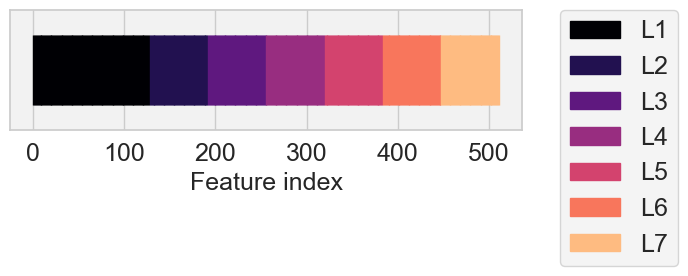

In [16]:
NN = 128
layerwise_tuning_masks = [np.zeros(shape=(int(4*NN))).astype(bool),
                np.zeros(shape=(int(4*NN))).astype(bool), 
                np.zeros(shape=(int(4*NN))).astype(bool), 
                np.zeros(shape=(int(4*NN))).astype(bool),
                np.zeros(shape=(int(4*NN))).astype(bool),
                np.zeros(shape=(int(4*NN))).astype(bool), 
                np.zeros(shape=(int(4*NN))).astype(bool)]
layerwise_tuning_masks[0][0:int(NN)] = True
layerwise_tuning_masks[1][int(NN):int(3*NN/2)] = True
layerwise_tuning_masks[2][int(3*NN/2):int(2*NN)] = True
layerwise_tuning_masks[3][int(2*NN):int(5*NN/2)] = True
layerwise_tuning_masks[4][int(5*NN/2):int(3*NN)] = True
layerwise_tuning_masks[5][int(3*NN):int(7*NN/2)] = True
layerwise_tuning_masks[6][int(7*NN/2):] = True

layer_cmap = [cm.get_cmap('magma', len(layerwise_tuning_masks)+1)(k) for k in range(len(layerwise_tuning_masks)+1)]

from PIL import Image
from matplotlib.patches import Patch

fig=plt.figure(figsize=(8, 2))
plt.subplots_adjust(left=0.01, bottom=0.35, right=.65, top=.95, wspace=0.16, hspace=0.)
legend_elements = [Patch(facecolor=layer_cmap[k], edgecolor=layer_cmap[k], label='L%d'%(k+1)) for k,tm in enumerate(layerwise_tuning_masks)]
for k,tm in enumerate(layerwise_tuning_masks):
    _=plt.plot(tm, marker='|', linestyle='None', color=layer_cmap[k], ms=50)
#_=plt.title('Feature index layer correspondence')
_=plt.xlabel('Feature index')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1.1))

In [17]:
filename = output_dir + "gnet8x_feature_layer_distribution%s"  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

---
# Bipartite tuning masks

C:\Users\jiahaozhang\AppData\Local\Temp\ipykernel_48148\49288751.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bipartite_cmap = [cm.get_cmap('magma', len(bipartite_tuning_masks)+1)(k) for k in range(len(bipartite_tuning_masks)+1)]


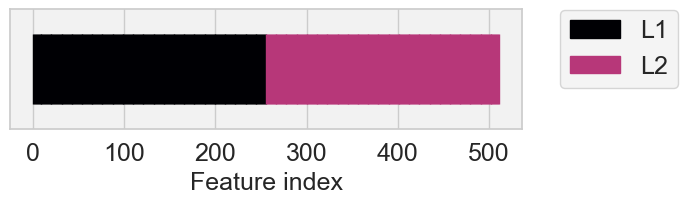

In [18]:
NN = 128
bipartite_tuning_masks = [np.zeros(shape=(int(4*NN))).astype(bool),
                          np.zeros(shape=(int(4*NN))).astype(bool)]
bipartite_tuning_masks[0][0:int(2*NN)] = True
bipartite_tuning_masks[1][int(2*NN):] = True

bipartite_cmap = [cm.get_cmap('magma', len(bipartite_tuning_masks)+1)(k) for k in range(len(bipartite_tuning_masks)+1)]

from PIL import Image
from matplotlib.patches import Patch

fig=plt.figure(figsize=(8, 2))
plt.subplots_adjust(left=0.01, bottom=0.35, right=.65, top=.95, wspace=0.16, hspace=0.)
legend_elements = [Patch(facecolor=bipartite_cmap[k], edgecolor=bipartite_cmap[k], label='L%d'%(k+1)) for k,tm in enumerate(bipartite_tuning_masks)]
for k,tm in enumerate(bipartite_tuning_masks):
    _=plt.plot(tm, marker='|', linestyle='None', color=bipartite_cmap[k], ms=50)
#_=plt.title('Feature index layer correspondence')
_=plt.xlabel('Feature index')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1.1))

In [23]:
filename = output_dir + "gnet8x_feature_bipartite_distribution%s"  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

---
# Rebuild model
Prediction will take a considerable amount of time.

In [19]:
from src.torch_joint_training_unpacked_sequences import *
from src.torch_gnet import Encoder
from src.torch_mpf import Torch_LayerwiseFWRF
from src.tuning import gnet8j_tuning_analysis, gnet8r_tuning_analysis, tuning_and_spread

def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

In [21]:
s=1
stim_subset = {}
voxel_subset = {}
ordering_subset = {}

val_stim_subset = {}
val_voxel_subset = {}
val_ordering_subset = {}

val_voxel_subset_2 = {}
val_ordering_subset_2 = {}

max_samples = 1000
max_voxels = 2000
val_max_samples = 2000
val_max_voxels = 2000

num_samples = min(max_samples, trn_voxel_data[s].shape[0])
num_voxels = min(max_voxels, trn_voxel_data[s].shape[1])
val_num_samples = min(val_max_samples, val_voxel_data[s].shape[0])
val_num_voxels = min(val_max_voxels, val_voxel_data[s].shape[1])

voxel_subset[s] = trn_voxel_data[s][:num_samples, :num_voxels]
ordering_subset[s] = trn_stim_ordering[s][:num_samples] 
stim_subset[s] = stim_data[s][ordering_subset[s]]

val_ordering_subset[s] = val_stim_ordering[s][:val_num_samples] 
val_voxel_subset[s] = val_voxel_data[s][:val_num_samples, :val_num_voxels]
val_stim_subset[s] = stim_data[s][val_ordering_subset[s]]

---
# Joined model tuning
## Layerwise GNet8j tuning

In [22]:
# already done once
'''subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc = \
     gnet8j_tuning_analysis(stim_data, val_voxel_data, val_stim_ordering, _pred_fn, joined_checkpoint, layerwise_tuning_masks, batch_size=100, n_resample=64, device=device)'''

'subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc =      gnet8j_tuning_analysis(stim_data, val_voxel_data, val_stim_ordering, _pred_fn, joined_checkpoint, layerwise_tuning_masks, batch_size=100, n_resample=64, device=device)'

In [38]:
from src.file_utility import save_stuff, flatten_dict, embed_dict

save_stuff( joined_model_dir + 'gnet8j_layerwise_tuning_var',
    flatten_dict({
            'val_cc': subject_total_val_cc,
            'incl_val_cc': subject_partition_incl_val_cc,
            'excl_val_cc': subject_partition_excl_val_cc
            }))

saved val_cc.1 in h5py file
saved incl_val_cc.1 in h5py file
saved excl_val_cc.1 in h5py file


In [23]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

3424

## GNet8j Bipartite tuning

In [24]:
# already done once
'''subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc = \
    gnet8j_tuning_analysis(stim_data, val_voxel_data, val_stim_ordering, _pred_fn, joined_checkpoint, bipartite_tuning_masks, batch_size=100, n_resample=64, device=device)'''

'subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc =     gnet8j_tuning_analysis(stim_data, val_voxel_data, val_stim_ordering, _pred_fn, joined_checkpoint, bipartite_tuning_masks, batch_size=100, n_resample=64, device=device)'

In [32]:
save_stuff( joined_model_dir + 'gnet8j_bibartite_tuning_var',
    flatten_dict({
            'val_cc': subject_total_val_cc,
            'incl_val_cc': subject_partition_incl_val_cc,
            'excl_val_cc': subject_partition_excl_val_cc
            }))

saved val_cc.1 in h5py file
saved incl_val_cc.1 in h5py file
saved excl_val_cc.1 in h5py file


---
# ROI-wise model tuning
## Layerwise GNet8r tuning

In [25]:
subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc = \
    gnet8r_tuning_analysis(stim_data, val_voxel_data, val_stim_ordering, _pred_fn, roiwise_checkpoint, layerwise_tuning_masks, batch_size=100, n_resample=64, device=device)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:15<00:00,  4.07it/s]
0it [00:00, ?it/s]
%|                                                                                           | 0/64 [00:00<?, ?it/s]
%|█▎                                                                                 | 1/64 [00:00<00:15,  4.14it/s]
%|██▌                                                                                | 2/64 [00:00<00:15,  4.02it/s]
%|███▉                                                                               | 3/64 [00:00<00:15,  4.05it/s]
%|█████▏                                                                             | 4/64 [00:00<00:14,  4.02it/s]
%|██████▍                                                                            | 5/64 [00:01<00:14,  4.05it/s]
%|███████▊                                                                           | 6/64 [00:01<00:14,  4.05it/s]
%|█████████                               

In [26]:
save_stuff( roiwise_model_dir + 'gnet8r_layerwise_tuning_var',
    flatten_dict({
            'val_cc': subject_total_val_cc,
            'incl_val_cc': subject_partition_incl_val_cc,
            'excl_val_cc': subject_partition_excl_val_cc
            }))

saved val_cc.1 in h5py file
saved incl_val_cc.1 in h5py file
saved excl_val_cc.1 in h5py file


## Bipartite GNet8r tuning

In [44]:
subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc = \
    gnet8r_tuning_analysis(stim_data, val_voxel_data, val_stim_ordering, _pred_fn, roiwise_checkpoint, bipartite_tuning_masks, batch_size=100, n_resample=64, device=device)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:14<00:00,  4.28it/s]
0it [00:00, ?it/s]
%|                                                                                           | 0/64 [00:00<?, ?it/s]
%|█▎                                                                                 | 1/64 [00:00<00:14,  4.25it/s]
%|██▌                                                                                | 2/64 [00:00<00:15,  4.05it/s]
%|███▉                                                                               | 3/64 [00:00<00:15,  4.06it/s]
%|█████▏                                                                             | 4/64 [00:00<00:14,  4.05it/s]
%|██████▍                                                                            | 5/64 [00:01<00:14,  4.06it/s]
%|███████▊                                                                           | 6/64 [00:01<00:14,  4.11it/s]
%|█████████                               

In [80]:
save_stuff( roiwise_model_dir + 'gnet8r_bipartite_tuning_var',
    flatten_dict({
            'val_cc': subject_total_val_cc,
            'incl_val_cc': subject_partition_incl_val_cc,
            'excl_val_cc': subject_partition_excl_val_cc
            }))

saved val_cc.1 in h5py file
saved incl_val_cc.1 in h5py file
saved excl_val_cc.1 in h5py file


In [78]:
gc.collect()
torch.cuda.empty_cache()